# Stop clustering
Clustering of public transit stops by agglomerative clustering

In [1]:
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
from pyproj import Proj, transform
import numpy as np
import matplotlib.pyplot as plt
from random import randint

from bokeh.plotting import figure, show, ColumnDataSource, output_file
from bokeh.io import output_notebook
output_notebook()
from bokeh.tile_providers import CARTODBPOSITRON

%matplotlib inline

Loading BokehJS ...

In [2]:
# path to a gtfs-stops-file
stops_path = r"C:\Dev\data\gtfsfp20192019-04-10\stops.txt"

In [3]:
df_stops = pd.read_csv(stops_path, sep=",")
print len(df_stops)
# restrict stops to Switzerland
df_stops_ch = df_stops[df_stops["stop_id"].str.startswith("85")]
print len(df_stops_ch)

30531
28867


In [4]:
df_stops_ch.head()

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station
1643,8500010,Basel SBB,47.547407,7.589551,NaN,8500010P
1644,8500010:0:1,Basel SBB,47.547467,7.589551,NaN,8500010P
1645,8500010:0:10,Basel SBB,47.548316,7.589551,NaN,8500010P
1646,8500010:0:11,Basel SBB,47.548255,7.589551,NaN,8500010P
1647,8500010:0:11AB,Basel SBB,47.547892,7.589551,NaN,8500010P


In [5]:
latlons_ch = df_stops_ch[["stop_lat", "stop_lon"]].values
names_ch = df_stops_ch["stop_name"]

In [6]:
from_proj  = Proj("+init=EPSG:4326") # WGS84
to_proj  = Proj("+init=EPSG:3857") # web mercator
xys_ch = [transform(from_proj, to_proj, lon, lat) for lat, lon in latlons_ch]

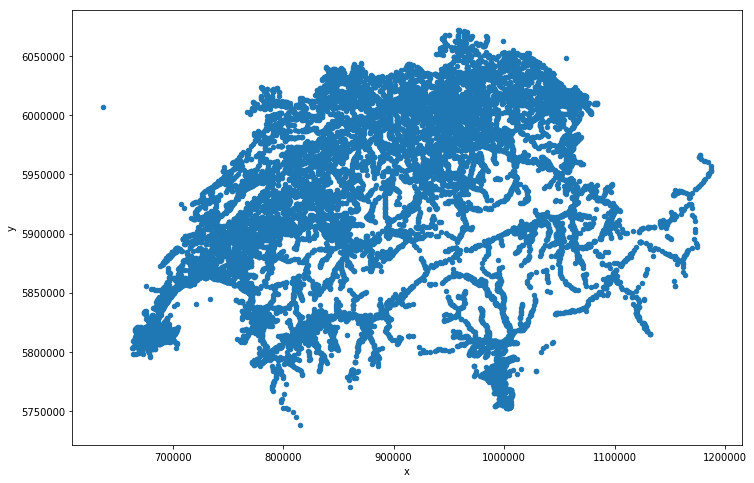

In [7]:
df_xys_ch = pd.DataFrame(xys_ch, columns=["x", "y"])
df_xys_ch.plot.scatter("x", "y", figsize=(12, 8))

In [8]:
clustering = AgglomerativeClustering(linkage="ward", n_clusters=2000)

In [9]:
%%time
clustering.fit(xys_ch)

Wall time: 2min 12s


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None,
            n_clusters=2000, pooling_func='deprecated')

In [10]:
def get_new_random_color(colors_so_far):
    def get_random_color():
        return (randint(0, 255) / 255., randint(0, 255) / 255., randint(0, 255) / 255.)
    while(True):
        new_color = get_random_color()
        if new_color in  colors_so_far:
            continue
        else:
            colors_so_far.add(new_color)
            return new_color

In [11]:
def get_colors(labels):
    clusters = set(labels)
    colors_so_far = set()
    colors_per_cluster = {}
    for c in clusters:
        colors_per_cluster[c] = get_new_random_color(colors_so_far)
    colors = [colors_per_cluster[l] for l in labels]
    return colors

In [12]:
def plot_clustering(xys, labels):
    plt.figure(figsize=(12, 8))
    plt.scatter(zip(*xys_ch)[0], zip(*xys_ch)[1], c=get_colors(labels))

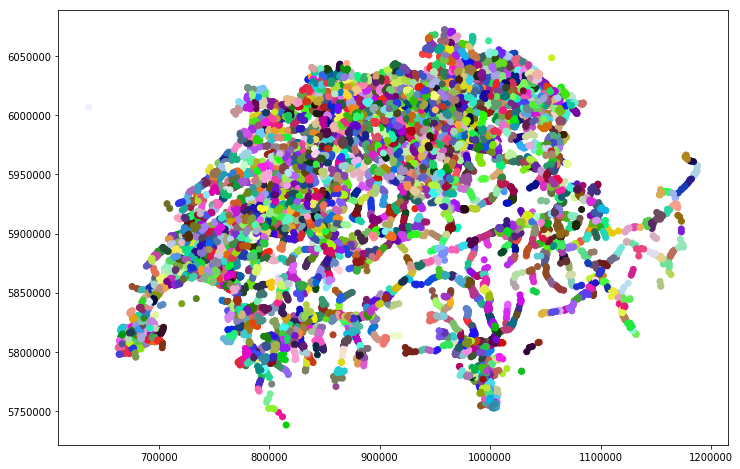

In [13]:
plot_clustering(xys_ch, clustering.labels_)

In [14]:
def plot_clustering_bokeh(xys, labels, names):
    
    source = ColumnDataSource(data=dict(
        x=zip(*xys_ch)[0],
        y=zip(*xys_ch)[1],
        labels=labels,
        names=names,
        colors = ["#%02x%02x%02x" % (int(r * 255), int(g * 255), int(b * 255)) for r, g, b in get_colors(labels)]
    ))
    TOOLTIPS = [
        ("cluster", "@labels"),
        ("name", "@names"),
    ]
    
    TOOLS = "hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

    p = figure(tools=TOOLS, tooltips=TOOLTIPS, plot_width=900, plot_height=600, match_aspect=True, x_axis_type="mercator", y_axis_type="mercator")   
    p.circle('x', 
             'y', 
             source=source,
             size=10,
             color='colors',
             alpha=0.6,
            )
    p.add_tile(CARTODBPOSITRON)

    output_file("stop_clustering.html", title="pt stop clustering")
    show(p)

In [15]:
plot_clustering_bokeh(xys_ch, clustering.labels_, names_ch)